In [38]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
filenames = []

for x in os.walk("."):
    path = x[0]
    for file in [f for f in x[2] if f.endswith(".csv")]:
        filenames.append(os.path.join(path, file))


In [5]:
# Esse bloco foi inteiramente reaproveitado do sisema de controle usado quando o teste foi feito

NL = 0
NM = 1
NS  = 2
Z = 3
P = 4


def fuzzify_triangular(value: int, center: int,
                       half_width: int, edge: int) -> int:
    if edge == -1 and value < center:
        return 256
    if edge == 1 and value > center:
        return 256
    if value > center + half_width:
        return 0
    if value < center - half_width:
        return 0

    centered_value = int(abs(value - center))
    return int((256 * (half_width - centered_value)) // half_width)


class FuzzyController:
    def __init__(self, temp, max_power):
        self.set_point = 0
        self.last_temp = temp               # 0~1024, a leitura do sensor

                               # N, Z, P
        self.fuzzy_delta_temp = (0, 0, 0)
                          # NL, NM, NS, Z, P
        self.fuzzy_error = (0,  0,  0, 0,  0)
                         # Z, ST, L, M, H
        self.fuzzy_power = (0, 0, 0, 0, 0)

        self.power = 0
        self.max_power = max_power

    def set_target(self, value):
        self.set_point = value

    def fuzzify_delta_temp(self, temp: int) -> None:
        delta_temp = int(temp - self.last_temp)
        self.last_temp = temp

        self.fuzzy_delta_temp = (
            fuzzify_triangular(delta_temp, -15, 15, -1),
            fuzzify_triangular(delta_temp, 0, 15, 0),
            fuzzify_triangular(delta_temp, 15, 15, 1)
        )

    def fuzzify_error(self, temp: int) -> None:
        error = temp - int(self.set_point)
        self.fuzzy_error = (
            fuzzify_triangular(error, -150, 50, -1),
            fuzzify_triangular(error, -100, 50,  0),
            fuzzify_triangular(error, -50, 50,  0),
            fuzzify_triangular(error,  0,  50,  0),
            fuzzify_triangular(error,  50, 50,  1)
        )

    def calculate_power(self):
        self.fuzzy_power = (
            max(self.fuzzy_error[P],
                self.fuzzy_delta_temp[2]),
            
            max(self.fuzzy_error[Z],
                min(self.fuzzy_error[NS], self.fuzzy_delta_temp[2])),
            
            max(self.fuzzy_error[NM],
                min(self.fuzzy_error[NS], self.fuzzy_delta_temp[1])),
            
            max(self.fuzzy_error[NL],
                min(self.fuzzy_error[NM], self.fuzzy_delta_temp[1])),
            
            min(self.fuzzy_error[NL], self.fuzzy_delta_temp[1])
        )

    def deffuzify_power(self):
        w_power = (0, 6, 20, 35, 50)     # Support member value
        power = 0
        membership_sum = 0
        for i in range(5):
            power += self.fuzzy_power[i] * w_power[i]
            membership_sum += self.fuzzy_power[i]

        power //= membership_sum

        self.power = power

        if self.power > self.max_power:
            self.power = self.max_power
        if self.power < 0:
            self.power = 0

    def run_step(self, temp):
        self.fuzzify_error(temp)
        self.fuzzify_delta_temp(temp)
        self.calculate_power()
        self.deffuzify_power()

        return self.power

In [56]:
def temp_to_reading(temp: float) -> int:
    reading = temp * 0.01
    reading = reading * 1024/2
    return int(reading)

print(temp_to_reading(109-20))

455


set: 100, estabilização: 92.90059882352944, potencia: 16
set: 120, estabilização: 109.07416532258064, potencia: 21
set: 140, estabilização: 126.29084313725492, potencia: 26
set: 40, estabilização: 43.0027220338983, potencia: 4
set: 60, estabilização: 59.10065000000001, potencia: 7
set: 80, estabilização: 75.8177727626459, potencia: 11
0.98633576181365
[-1.54840819]
[[0.048526]]


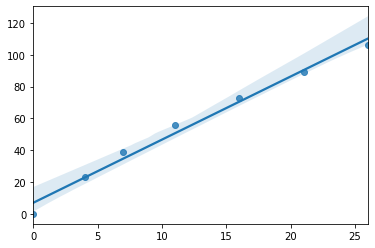

In [53]:
powers = [0, ]
temps = [0, ]

for filename in filenames:
    df = pd.read_csv(filename)
    df["time"] = df["time"] - df["time"][0]
    set_point = round(df["set_point"].mean())
    
    tail = df.where(df["time"] > (df["time"].max() - 300))
    out_mean = tail["S5"].mean()
    out_reading = temp_to_reading(out_mean)
    
    controller = FuzzyController(out_reading, 120)
    controller.set_target(temp_to_reading(set_point))
    controller.run_step(out_reading)
    controller.run_step(out_reading)
    
    temps.append(out_mean - 20)
    powers.append(controller.power)
    
    print(f"set: {set_point}, estabilização: {out_mean}, potencia: {controller.power}")

sns.regplot(x=powers, y=temps)

x = np.array(list(map(temp_to_reading, temps))).reshape(7, 1)
y = np.array(powers).reshape(7, 1)

model = LinearRegression()
model.fit(x, y)

print(model.score(x, y))
print(model.intercept_)
print(model.coef_)
# power_st = (read_set - read_room)//21 - 1

Com esses resultados, chegou-se no valor de um aumento na potência equivalente ao (set point - temperatura ambiente) / 21 para que o sistema consiga se adaptar